Import **Dataset** file and unzip it...

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !unzip '/content/dataset.zip'
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Data Analysis/dataset2.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


**Data Pre Processing**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

dataset_path = os.listdir('dataset')
print(dataset_path) # what kind classes in this dataset

print('Folder: ', len(dataset_path))


['non cancer', 'cancer']
Folder:  2


In [ ]:
class_lebels = []

for items in dataset_path:
  # get all the file names
  all_classes = os.listdir('dataset' + '/' + items)
  # print(all_classes[:10])

  for room in all_classes:
    class_lebels.append((items, str('dataset_path'+'/'+items)+'/'+room))
    # print(class_lebels[:5])

In [ ]:
# Build a DataFrame

df = pd.DataFrame(data=class_lebels, columns=['labels', 'image'])
print(df.head())
print(df.tail())

       labels                                          image
0  non cancer  dataset_path/non cancer/Normal case (113).jpg
1  non cancer   dataset_path/non cancer/Normal case (44).jpg
2  non cancer   dataset_path/non cancer/Normal case (80).jpg
3  non cancer  dataset_path/non cancer/Normal case (189).jpg
4  non cancer  dataset_path/non cancer/Normal case (244).jpg
      labels                                         image
1411  cancer  dataset_path/cancer/Malignant case (378).jpg
1412  cancer                dataset_path/cancer/000114.png
1413  cancer  dataset_path/cancer/Malignant case (214).jpg
1414  cancer   dataset_path/cancer/Malignant case (15).jpg
1415  cancer            dataset_path/cancer/000158 (5).png


In [ ]:
print('Total Images: ', len(df))
lebel_count = df['labels'].value_counts()
print(lebel_count)

Total Images:  1416
cancer        1016
non cancer     400
Name: labels, dtype: int64


In [ ]:
# resize image to EfficiencyNetB4 = 380
import cv2
path = 'dataset/'
dataset_path = os.listdir('dataset')

im_size = 380

images = []
labels = []

for i in dataset_path:
  data_path = path + str(i)
  filenames = [i for i in os.listdir(data_path)]

  for f in filenames:
    img = cv2.imread(data_path + '/' + f)
    img = cv2.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(i)

Put the image into Array using Numpy.

In [ ]:
# This model takes image into shape (380, 380, 3) and the input data should range (0:255)

images = np.array(images)

images = images.astype('float32') / 255.0
print('Image No, image size, color')
images.shape

Image No, image size, color


(1416, 380, 380, 3)

Convert value to Binary

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
y = df['labels'].values
print(y)

y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
print(y)

['non cancer' 'non cancer' 'non cancer' ... 'cancer' 'cancer' 'cancer']
[1 1 1 ... 0 0 0]


In [ ]:
y = y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder = 'passthrough')
Y = ct.fit_transform(y)
print(Y[:5])
print(Y[35:])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


**Train and Test the Data**

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, Y = shuffle(images, Y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size = 0.05, random_state=415)

# inspect the train and test shape
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1345, 380, 380, 3)
(1345, 2)
(71, 380, 380, 3)
(71, 2)


In [ ]:
from tensorflow import keras
from keras import layers
from keras.applications import EfficientNetB4

num_classes = 2
img_size = 380
size = (img_size, img_size)

inputs = layers.Input(shape=(img_size, img_size, 3))

# using model without transfer learning
outputs = EfficientNetB4(include_top=True, weights=None, classes=num_classes)(inputs)


In [ ]:

model = tf.keras.Model(inputs, outputs)
# learning_rate = 0.01
# optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
hist = model.fit(train_x, train_y, epochs=5, verbose=2, batch_size=6)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 380, 380, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 2)                17677409  
                                                                 
Total params: 17,677,409
Trainable params: 17,552,202
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/5
225/225 - 177s - loss: 2.5369 - accuracy: 0.6587 - 177s/epoch - 786ms/step
Epoch 2/5
225/225 - 82s - loss: 0.9736 - accuracy: 0.6922 - 82s/epoch - 364ms/step
Epoch 3/5
225/225 - 82s - loss: 0.7675 - accuracy: 0.7323 - 82s/epoch - 364ms/step
Epoch 4/5
225/225 - 82s - loss: 0.7655 - accuracy: 0.7175 - 82s/epoch - 364ms/step
Epoch 5/5
225/225 - 82s - loss: 0.6525 - accuracy: 0.7279 - 82s/epoch - 364ms/step


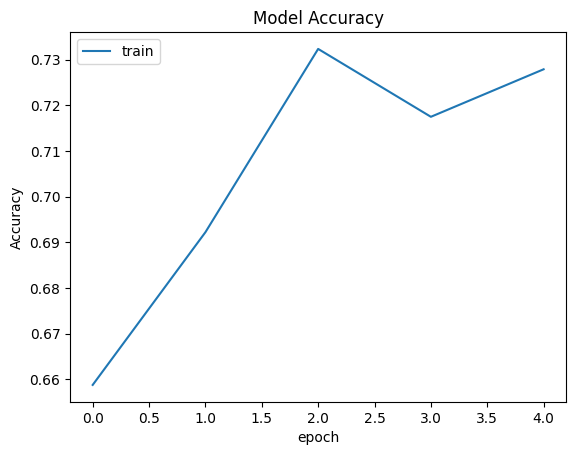

In [ ]:
def plot_hist(hist):
  plt.plot(hist.history['accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'], loc='upper left')
  plt.show

plot_hist(hist)

In [ ]:
preds = model.evaluate(test_x, test_y)
print("Loss = ", str(preds[0]))
print("Accuracy = ", str(preds[1]))

3/3 [==============================] - 7s 681ms/step - loss: 0.4839 - accuracy: 0.7324
Loss =  0.4839242100715637
Accuracy =  0.7323943376541138


Input image:  (1, 380, 380, 3)


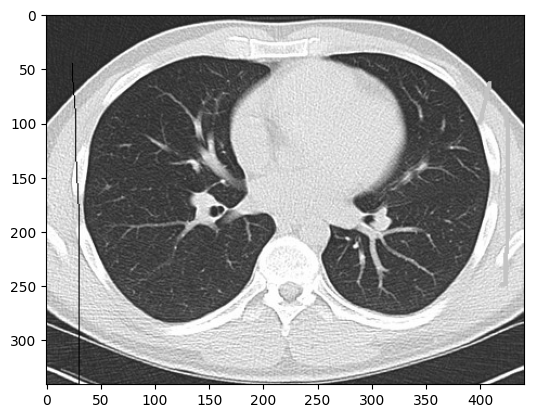

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow


img_path = "/content/drive/MyDrive/Data Analysis/image_1.png"

img = cv2.imread(img_path)
img = cv2.resize(img, (380, 380))
x = tf.keras.preprocessing.image.img_to_array(img)

# x = np.array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
print("Input image: ", x.shape)

my_image = imread(img_path)
imshow(my_image)



In [ ]:
preds = model.predict(x)


# predicted_class = np.argmax(preds)
print("cancer[0], non cancer[1]")
# predicted_class
preds

1/1 [==============================] - 0s 31ms/step
cancer[0], non cancer[1]


array([[1., 0.]], dtype=float32)

Succesfully Done